### 1. Import Libraries and Fetch Data

In [13]:
import pandas as pd
from yahoo_fin import stock_info as si
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# Set a random seed for reproducibility
np.random.seed(42)

# Fetch historical data for the past two years up until 2024-02-09
end_date = datetime(2024, 2, 9)
start_date = end_date - timedelta(days=2*365)  # Approximately two years

# Get historical data for AAPL
data = si.get_data('AAPL', start_date=start_date, end_date=end_date)

# Reset index to have a column with dates and rename it to 'date'
data.reset_index(inplace=True)
data.rename(columns={'index': 'date'}, inplace=True)

display(data)


,date,open,high,low,close,adjclose,volume,ticker
0,2022-02-09,176.050003,176.649994,174.899994,176.279999,174.052200,71285000,AAPL
1,2022-02-10,174.139999,175.479996,171.550003,172.119995,169.944763,90865900,AAPL
2,2022-02-11,172.330002,173.080002,168.039993,168.639999,166.508774,98670700,AAPL
3,2022-02-14,167.369995,169.580002,166.559998,168.880005,166.745728,86185500,AAPL
4,2022-02-15,170.970001,172.949997,170.250000,172.789993,170.606323,62527400,AAPL
...,...,...,...,...,...,...,...,...
497,2024-02-02,179.860001,187.330002,179.250000,185.850006,185.361740,102518000,AAPL
498,2024-02-05,188.149994,189.250000,185.839996,187.679993,187.186920,69668800,AAPL
499,2024-02-06,186.860001,189.309998,186.770004,189.300003,188.802673,43490800,AAPL
500,2024-02-07,190.639999,191.050003,188.610001,189.410004,188.912384,53439000,AAPL


### 2. Calculate Technical Indicators - Feature Engineering

In [14]:
# Simple Moving Average (SMA)
data['SMA_10'] = data['close'].rolling(window=10).mean()

# Relative Strength Index (RSI)
delta = data['close'].diff(1)
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
data['RSI_14'] = 100 - (100 / (1 + rs))

# Bollinger Bands
data['20_SMA'] = data['close'].rolling(window=20).mean()
data['20_std'] = data['close'].rolling(window=20).std()
data['Upper_Band'] = data['20_SMA'] + (data['20_std'] * 2)
data['Lower_Band'] = data['20_SMA'] - (data['20_std'] * 2)

# Create lagged closing prices
data['Close_1'] = data['close'].shift(1)
data['Close_2'] = data['close'].shift(2)

# Drop rows with NaN values (due to shifting and rolling calculations)
data.dropna(inplace=True)

display(data)


,date,open,high,low,close,adjclose,volume,ticker,SMA_10,RSI_14,20_SMA,20_std,Upper_Band,Lower_Band,Close_1,Close_2
19,2022-03-09,161.479996,163.410004,159.410004,162.949997,160.890671,91454900,AAPL,163.156000,37.179469,166.169501,4.873161,175.915822,156.423179,157.440002,159.300003
20,2022-03-10,160.199997,160.389999,155.979996,158.520004,156.516663,105342000,AAPL,162.734000,36.439778,165.281501,4.540624,174.362748,156.200254,162.949997,157.440002
21,2022-03-11,158.929993,159.279999,154.500000,154.729996,152.774551,96970100,AAPL,161.721999,34.446900,164.412001,4.818695,174.049391,154.774611,158.520004,162.949997
22,2022-03-14,151.449997,154.119995,150.100006,150.619995,148.716492,108732100,AAPL,160.271999,33.509847,163.511001,5.606782,174.724565,152.297437,154.729996,158.520004
23,2022-03-15,150.899994,155.570007,150.380005,155.089996,153.129990,92964300,AAPL,159.460999,44.037340,162.821500,5.757663,174.336826,151.306175,150.619995,154.729996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497,2024-02-02,179.860001,187.330002,179.250000,185.850006,185.361740,102518000,AAPL,190.703998,49.883308,188.155998,4.309938,196.775873,179.536123,186.860001,184.399994
498,2024-02-05,188.149994,189.250000,185.839996,187.679993,187.186920,69668800,AAPL,190.082997,56.857413,188.480998,3.989362,196.459721,180.502275,185.850006,186.860001
499,2024-02-06,186.860001,189.309998,186.770004,189.300003,188.802673,43490800,AAPL,189.494998,60.960283,188.667999,3.932484,196.532967,180.803030,187.679993,185.850006
500,2024-02-07,190.639999,191.050003,188.610001,189.410004,188.912384,53439000,AAPL,188.985999,51.600984,188.881499,3.845821,196.573140,181.189857,189.300003,187.679993


### 3. Prepare Data for LSTM

In [15]:
# Select the features and normalize
features = ['close', 'SMA_10', 'RSI_14', 'Upper_Band', 'Lower_Band', 'Close_1', 'Close_2']
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[features])

# Split the dataset into 80% training and 20% testing
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Convert the data into sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 0])  # '0' refers to the 'close' column
    return np.array(X), np.array(y)

seq_length = 60
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Reshape the input to be 3-dimensional [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], len(features)))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], len(features)))

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(326, 60, 7) (326,)
(37, 60, 7) (37,)


### 4. Build and Train the LSTM Model


Epoch 1/100


c:\Users\kahbe\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 0.1753 - val_loss: 0.0678
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0281 - val_loss: 0.0048
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0259 - val_loss: 0.0368
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0186 - val_loss: 0.0050
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0137 - val_loss: 0.0099
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0114 - val_loss: 0.0073
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0113 - val_loss: 0.0060
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0125 - val_loss: 0.0074
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0108 - val_loss: 0.0073
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0089 - val_loss: 0.0068
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0093 - val_loss: 0.0066
Epoch 12/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0

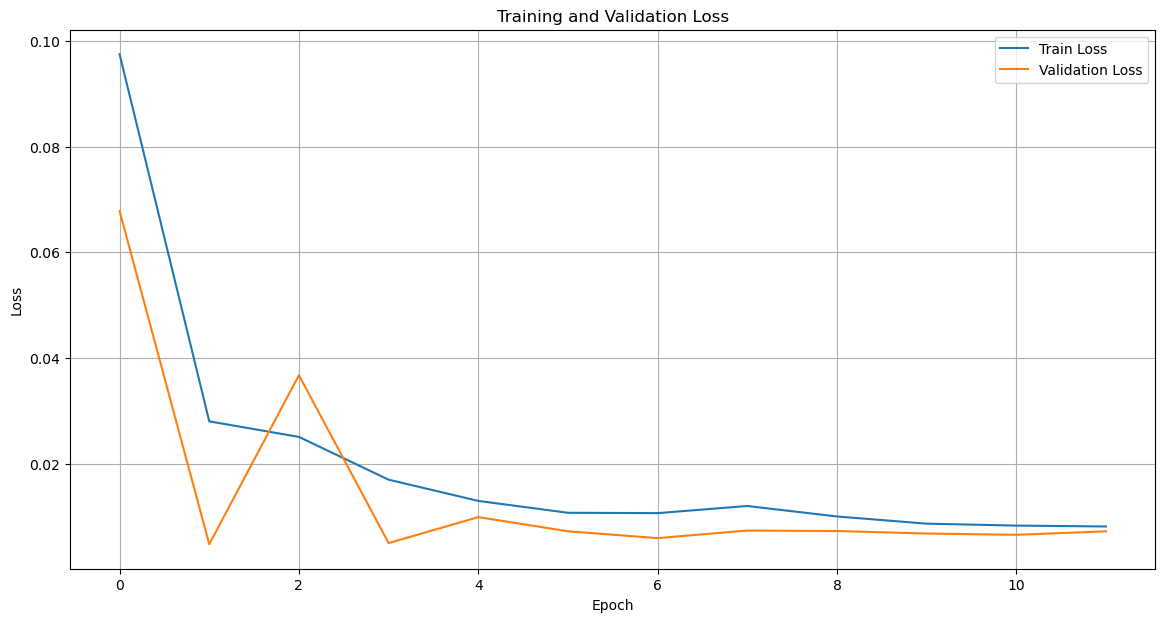

In [21]:
# Build the LSTM model
# MAE: 3.63549217932102
# RMSE: 4.239796866956602
# R²: 0.14574094924023828
# MAPE: 1.914361447800832
# model = Sequential()
# model.add(LSTM(units=50, return_sequences=True, input_shape=(seq_length, len(features))))
# model.add(Dropout(0.2))
# model.add(LSTM(units=50, return_sequences=False))
# model.add(Dropout(0.2))
# model.add(Dense(units=25))
# model.add(Dense(units=1))


# Build the LSTM model with updated architecture
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(seq_length, len(features))))
model.add(Dropout(0.3))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(units=25))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model with early stopping
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop])

# Plot training and validation loss
plt.figure(figsize=(14, 7))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


### 5. Make Predictions and Evaluate the Model

In [22]:
# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverse transform the predictions and actual values
train_predictions = scaler.inverse_transform(np.concatenate((train_predictions, np.zeros((train_predictions.shape[0], len(features) - 1))), axis=1))[:, 0]
y_train_actual = scaler.inverse_transform(np.concatenate((y_train.reshape(-1, 1), np.zeros((y_train.shape[0], len(features) - 1))), axis=1))[:, 0]
test_predictions = scaler.inverse_transform(np.concatenate((test_predictions, np.zeros((test_predictions.shape[0], len(features) - 1))), axis=1))[:, 0]
y_test_actual = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], len(features) - 1))), axis=1))[:, 0]

# Evaluate the model
mae = mean_absolute_error(y_test_actual, test_predictions)
rmse = np.sqrt(mean_squared_error(y_test_actual, test_predictions))
r2 = r2_score(y_test_actual, test_predictions)
mape = np.mean(np.abs((y_test_actual - test_predictions) / y_test_actual)) * 100

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")
print(f"MAPE: {mape}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
MAE: 4.132129025223143
RMSE: 5.067611405009173
R²: -0.22041096044944353
MAPE: 2.1968391663731714


### 6. Results Visualization

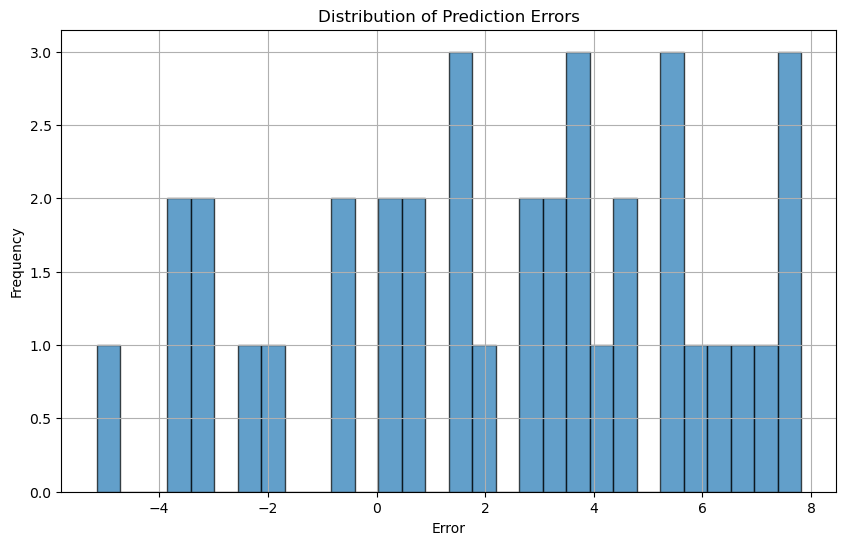

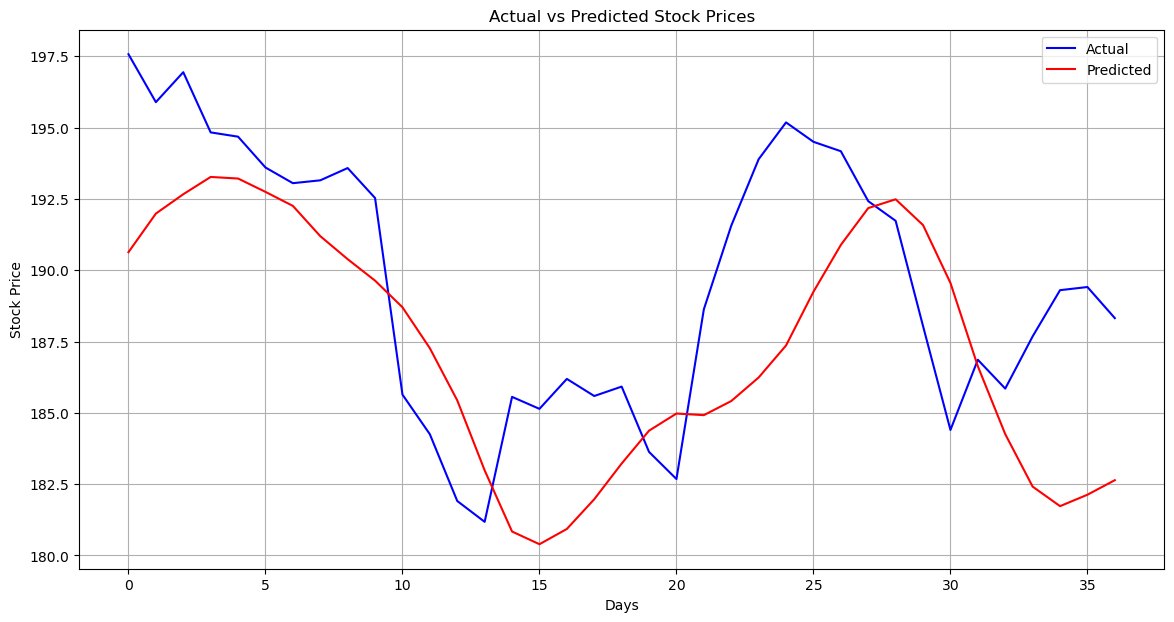

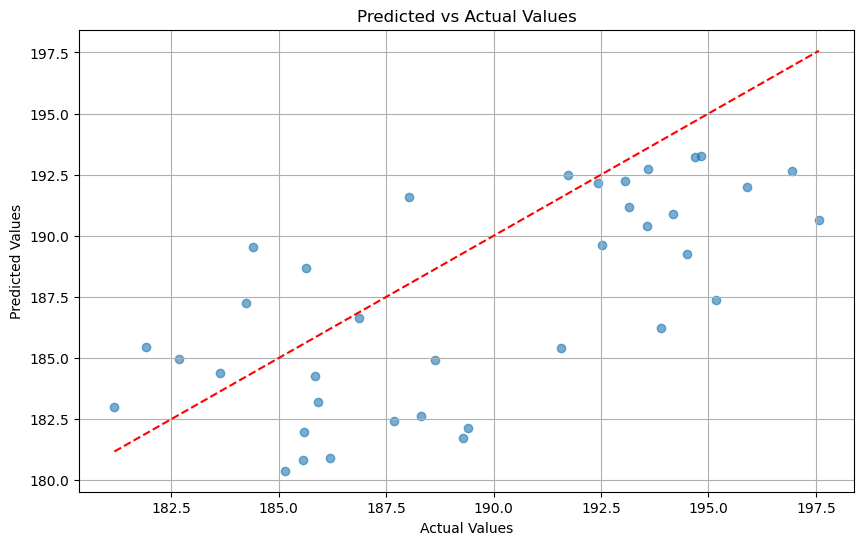

In [19]:
# Residuals plot
residuals = y_test_actual - test_predictions
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Prediction Errors')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, label='Actual', color='blue')
plt.plot(test_predictions, label='Predicted', color='red')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

# Scatter plot of predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test_actual, test_predictions, alpha=0.6)
plt.plot([min(y_test_actual), max(y_test_actual)], [min(y_test_actual), max(y_test_actual)], color='red', linestyle='--')
plt.title('Predicted vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()


(326, 60, 7) (326,)
(37, 60, 7) (37,)


c:\Users\kahbe\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 0.0926 - val_loss: 0.0592
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0202 - val_loss: 0.0041
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0146 - val_loss: 0.0046
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0110 - val_loss: 0.0061
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0101 - val_loss: 0.0050
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0086 - val_loss: 0.0095
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0086 - val_loss: 0.0091
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0091 - val_loss: 0.0084
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0085 - val_loss: 0.0203
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0091 - val_loss: 0.0118
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0087 - val_loss: 0.0078
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0

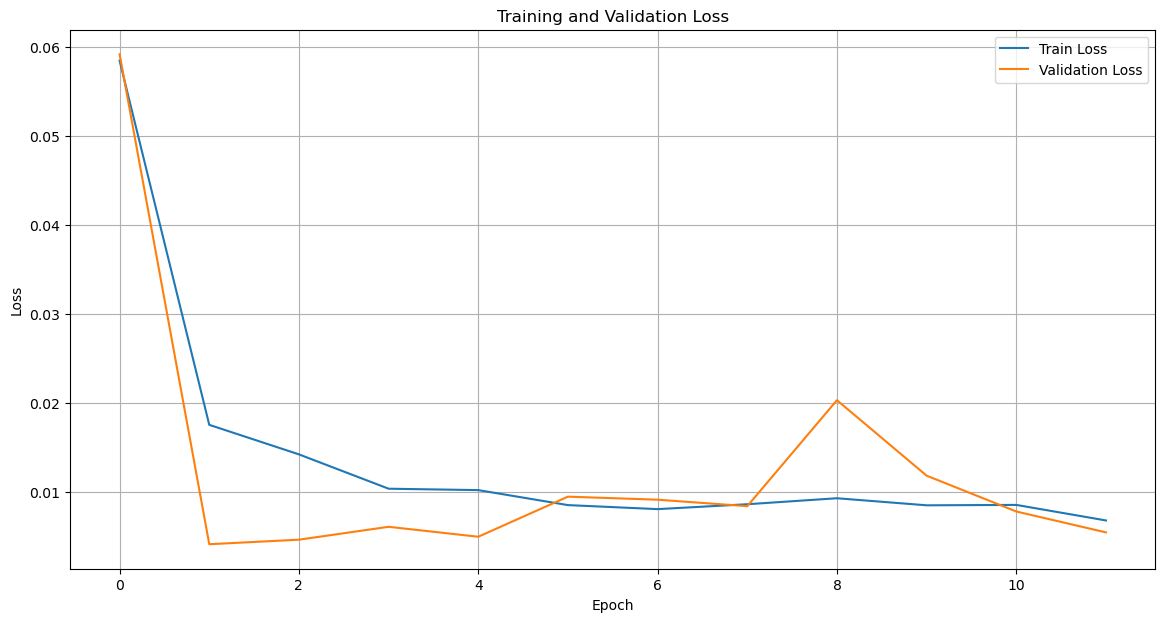

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
MAE: 3.78264102328178
RMSE: 4.69255878882599
R²: -0.04645108837923262
MAPE: 2.004861326751916


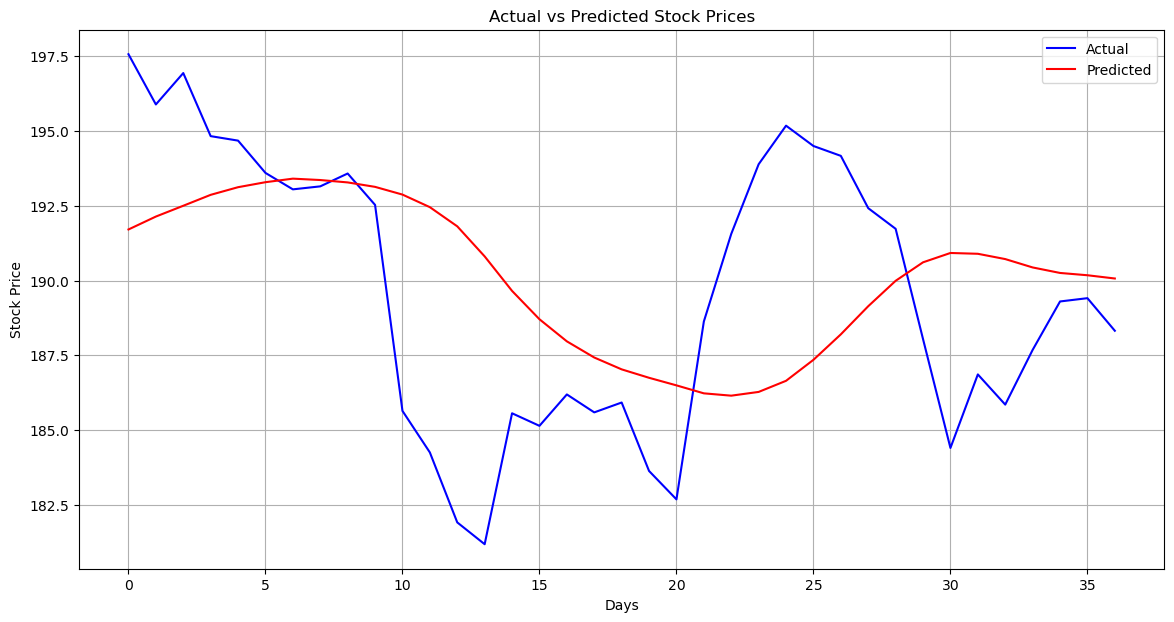

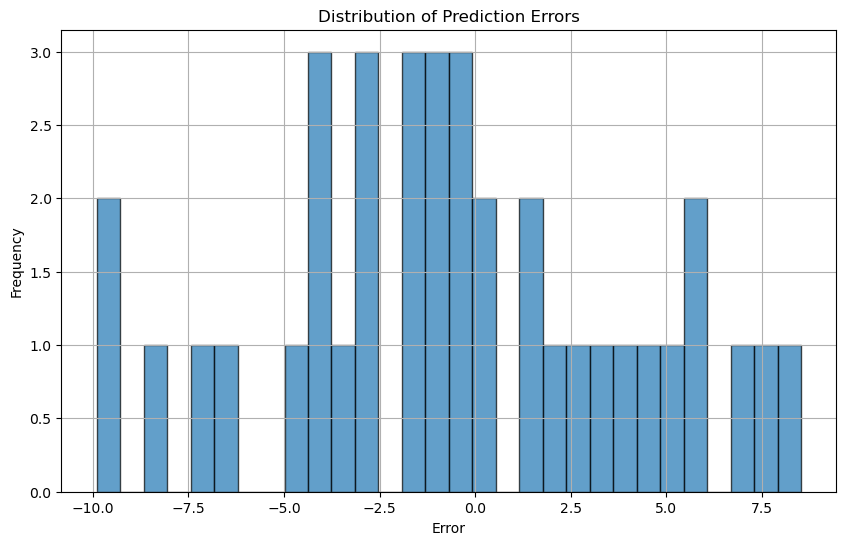

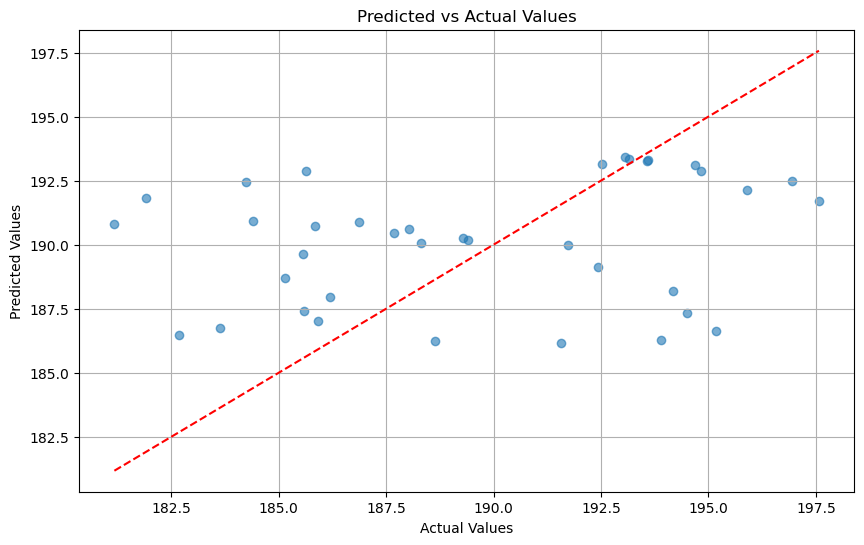

In [23]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from datetime import datetime, timedelta
from yahoo_fin import stock_info as si
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

# Set a random seed for reproducibility
np.random.seed(42)

# Fetch historical data for the past two years up until 2024-02-09
end_date = datetime(2024, 2, 9)
start_date = end_date - timedelta(days=2*365)  # Approximately two years

# Get historical data for AAPL
data = si.get_data('AAPL', start_date=start_date, end_date=end_date)

# Reset index to have a column with dates and rename it to 'date'
data.reset_index(inplace=True)
data.rename(columns={'index': 'date'}, inplace=True)

# Calculate technical indicators
data['SMA_10'] = data['close'].rolling(window=10).mean()
delta = data['close'].diff(1)
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
data['RSI_14'] = 100 - (100 / (1 + rs))
data['20_SMA'] = data['close'].rolling(window=20).mean()
data['20_std'] = data['close'].rolling(window=20).std()
data['Upper_Band'] = data['20_SMA'] + (data['20_std'] * 2)
data['Lower_Band'] = data['20_SMA'] - (data['20_std'] * 2)
data['Close_1'] = data['close'].shift(1)
data['Close_2'] = data['close'].shift(2)

# Drop rows with NaN values (due to shifting and rolling calculations)
data.dropna(inplace=True)

# Select the features and normalize
features = ['close', 'SMA_10', 'RSI_14', 'Upper_Band', 'Lower_Band', 'Close_1', 'Close_2']
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[features])

# Split the dataset into training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Convert the data into sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 0])  # '0' refers to the 'close' column
    return np.array(X), np.array(y)

seq_length = 60
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Reshape the input to be 3-dimensional [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], len(features)))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], len(features)))

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

# Build the LSTM model with updated architecture
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(seq_length, len(features))))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=25, activation='relu'))
model.add(Dense(units=1))

# Experiment with different optimizers
optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the model with early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop])

# Plot training and validation loss
plt.figure(figsize=(14, 7))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverse transform the predictions and actual values
train_predictions = scaler.inverse_transform(np.concatenate((train_predictions, np.zeros((train_predictions.shape[0], len(features) - 1))), axis=1))[:, 0]
y_train_actual = scaler.inverse_transform(np.concatenate((y_train.reshape(-1, 1), np.zeros((y_train.shape[0], len(features) - 1))), axis=1))[:, 0]
test_predictions = scaler.inverse_transform(np.concatenate((test_predictions, np.zeros((test_predictions.shape[0], len(features) - 1))), axis=1))[:, 0]
y_test_actual = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], len(features) - 1))), axis=1))[:, 0]

# Evaluate the model
mae = mean_absolute_error(y_test_actual, test_predictions)
rmse = np.sqrt(mean_squared_error(y_test_actual, test_predictions))
r2 = r2_score(y_test_actual, test_predictions)
mape = np.mean(np.abs((y_test_actual - test_predictions) / y_test_actual)) * 100

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")
print(f"MAPE: {mape}")

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, label='Actual', color='blue')
plt.plot(test_predictions, label='Predicted', color='red')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

# Residuals plot
residuals = y_test_actual - test_predictions
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Prediction Errors')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Scatter plot of predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test_actual, test_predictions, alpha=0.6)
plt.plot([min(y_test_actual), max(y_test_actual)], [min(y_test_actual), max(y_test_actual)], color='red', linestyle='--')
plt.title('Predicted vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()


(326, 60, 7) (326,)
(37, 60, 7) (37,)
Epoch 1/50


c:\Users\kahbe\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 0.2374 - val_loss: 0.0062
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0393 - val_loss: 0.0654
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0234 - val_loss: 0.0063
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0163 - val_loss: 0.0074
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0121 - val_loss: 0.0060
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0106 - val_loss: 0.0059
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0096 - val_loss: 0.0076
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0103 - val_loss: 0.0084
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0087 - val_loss: 0.0062
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0088 - val_loss: 0.0090
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0101 - val_loss: 0.0113
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0100 - val_l

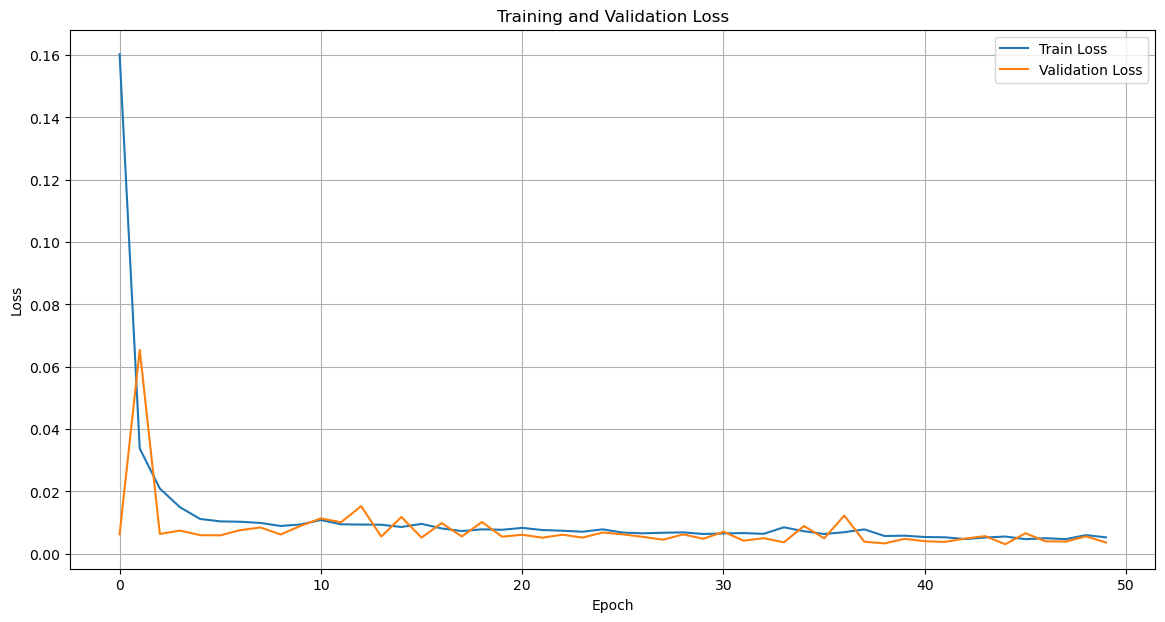

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
MAE: 3.3170784500637844
RMSE: 4.037372498224076
R²: 0.2253649737766802
MAPE: 1.7477826031271597


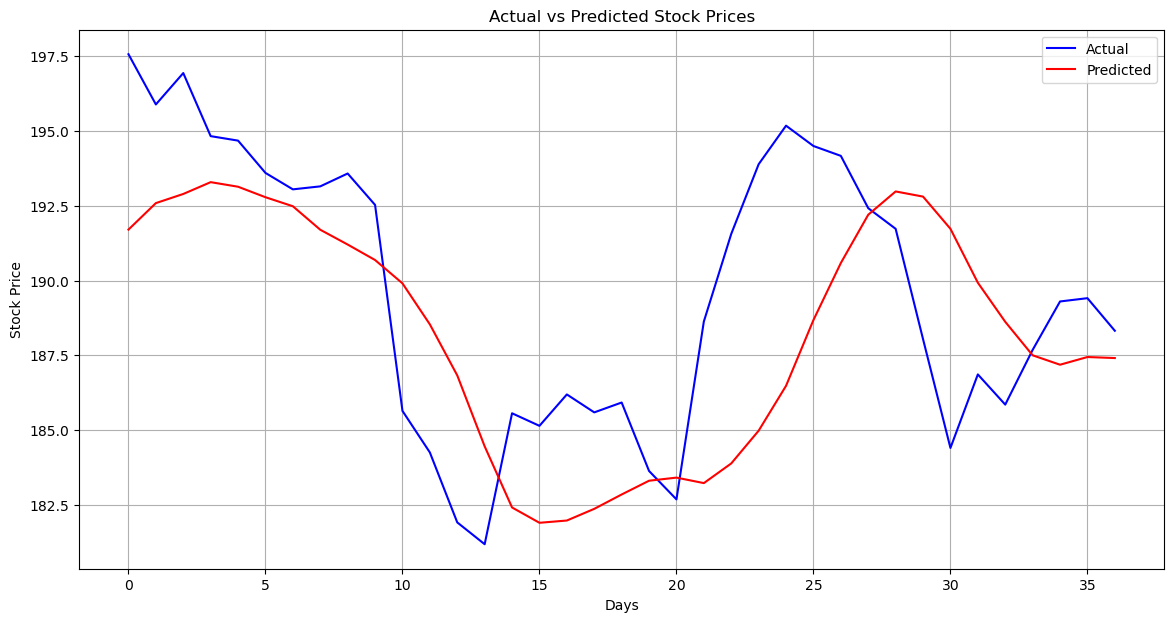

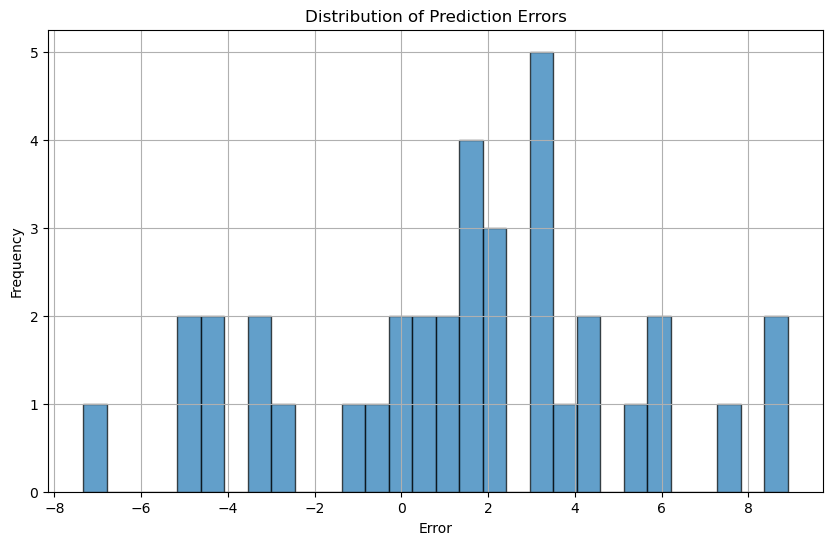

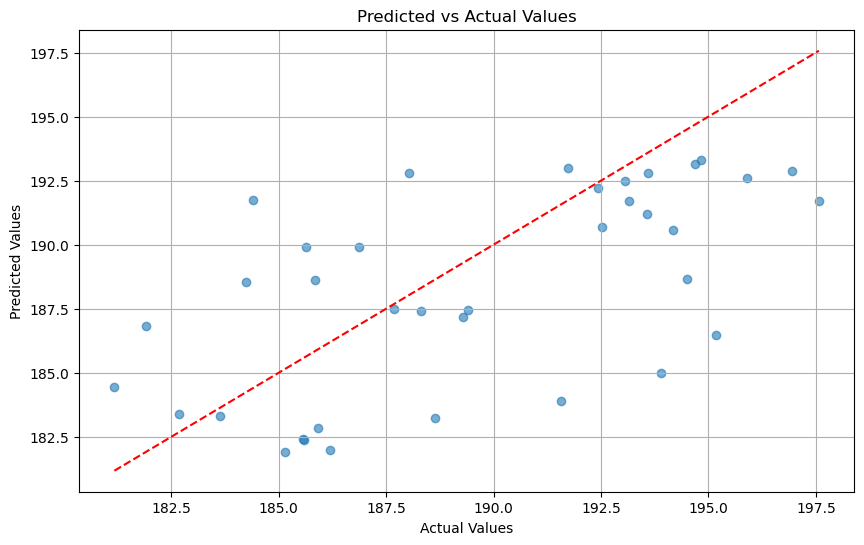

In [24]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from datetime import datetime, timedelta
from yahoo_fin import stock_info as si
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

# Set a random seed for reproducibility
np.random.seed(42)

# Fetch historical data for the past two years up until 2024-02-09
end_date = datetime(2024, 2, 9)
start_date = end_date - timedelta(days=2*365)  # Approximately two years

# Get historical data for AAPL
data = si.get_data('AAPL', start_date=start_date, end_date=end_date)

# Reset index to have a column with dates and rename it to 'date'
data.reset_index(inplace=True)
data.rename(columns={'index': 'date'}, inplace=True)

# Calculate technical indicators
data['SMA_10'] = data['close'].rolling(window=10).mean()
delta = data['close'].diff(1)
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
data['RSI_14'] = 100 - (100 / (1 + rs))
data['20_SMA'] = data['close'].rolling(window=20).mean()
data['20_std'] = data['close'].rolling(window=20).std()
data['Upper_Band'] = data['20_SMA'] + (data['20_std'] * 2)
data['Lower_Band'] = data['20_SMA'] - (data['20_std'] * 2)
data['Close_1'] = data['close'].shift(1)
data['Close_2'] = data['close'].shift(2)

# Drop rows with NaN values (due to shifting and rolling calculations)
data.dropna(inplace=True)

# Select the features and normalize
features = ['close', 'SMA_10', 'RSI_14', 'Upper_Band', 'Lower_Band', 'Close_1', 'Close_2']
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[features])

# Split the dataset into training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Convert the data into sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 0])  # '0' refers to the 'close' column
    return np.array(X), np.array(y)

seq_length = 60
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Reshape the input to be 3-dimensional [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], len(features)))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], len(features)))

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

# Build the LSTM model with updated architecture
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(seq_length, len(features))))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=25, activation='relu'))
model.add(Dense(units=1))

# Experiment with different optimizers
optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the model with early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop])

# Plot training and validation loss
plt.figure(figsize=(14, 7))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverse transform the predictions and actual values
train_predictions = scaler.inverse_transform(np.concatenate((train_predictions, np.zeros((train_predictions.shape[0], len(features) - 1))), axis=1))[:, 0]
y_train_actual = scaler.inverse_transform(np.concatenate((y_train.reshape(-1, 1), np.zeros((y_train.shape[0], len(features) - 1))), axis=1))[:, 0]
test_predictions = scaler.inverse_transform(np.concatenate((test_predictions, np.zeros((test_predictions.shape[0], len(features) - 1))), axis=1))[:, 0]
y_test_actual = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], len(features) - 1))), axis=1))[:, 0]

# Evaluate the model
mae = mean_absolute_error(y_test_actual, test_predictions)
rmse = np.sqrt(mean_squared_error(y_test_actual, test_predictions))
r2 = r2_score(y_test_actual, test_predictions)
mape = np.mean(np.abs((y_test_actual - test_predictions) / y_test_actual)) * 100

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")
print(f"MAPE: {mape}")

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, label='Actual', color='blue')
plt.plot(test_predictions, label='Predicted', color='red')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

# Residuals plot
residuals = y_test_actual - test_predictions
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Prediction Errors')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Scatter plot of predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test_actual, test_predictions, alpha=0.6)
plt.plot([min(y_test_actual), max(y_test_actual)], [min(y_test_actual), max(y_test_actual)], color='red', linestyle='--')
plt.title('Predicted vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()


(326, 60, 7) (326,)
(37, 60, 7) (37,)
Training with params: {'batch_size': 32, 'dropout': 0.2, 'learning_rate': 0.001, 'optimizer': <class 'keras.src.optimizers.adam.Adam'>, 'units': 50}


c:\Users\kahbe\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 420ms/step
Training with params: {'batch_size': 32, 'dropout': 0.2, 'learning_rate': 0.001, 'optimizer': <class 'keras.src.optimizers.adam.Adam'>, 'units': 100}


c:\Users\kahbe\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/stepWARNING:tensorflow:6 out of the last 17 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000021D222D7940> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step
Training with params: {'batch_size': 32, 'dropout': 0.2, 'learning_rate': 0.001, 'optimizer': <class 'keras.src.optimizers.rmsprop.RMSprop'>, 'units': 50}


c:\Users\kahbe\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step
Training with params: {'batch_size': 32, 'dropout': 0.2, 'learning_rate': 0.001, 'optimizer': <class 'keras.src.optimizers.rmsprop.RMSprop'>, 'units': 100}


c:\Users\kahbe\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step
Training with params: {'batch_size': 32, 'dropout': 0.2, 'learning_rate': 0.001, 'optimizer': <class 'keras.src.optimizers.nadam.Nadam'>, 'units': 50}


c:\Users\kahbe\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step
Training with params: {'batch_size': 32, 'dropout': 0.2, 'learning_rate': 0.001, 'optimizer': <class 'keras.src.optimizers.nadam.Nadam'>, 'units': 100}


c:\Users\kahbe\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step
Training with params: {'batch_size': 32, 'dropout': 0.2, 'learning_rate': 0.005, 'optimizer': <class 'keras.src.optimizers.adam.Adam'>, 'units': 50}


c:\Users\kahbe\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step
Training with params: {'batch_size': 32, 'dropout': 0.2, 'learning_rate': 0.005, 'optimizer': <class 'keras.src.optimizers.adam.Adam'>, 'units': 100}


c:\Users\kahbe\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step
Training with params: {'batch_size': 32, 'dropout': 0.2, 'learning_rate': 0.005, 'optimizer': <class 'keras.src.optimizers.rmsprop.RMSprop'>, 'units': 50}


c:\Users\kahbe\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 387ms/step
Training with params: {'batch_size': 32, 'dropout': 0.2, 'learning_rate': 0.005, 'optimizer': <class 'keras.src.optimizers.rmsprop.RMSprop'>, 'units': 100}


c:\Users\kahbe\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step
Training with params: {'batch_size': 32, 'dropout': 0.2, 'learning_rate': 0.005, 'optimizer': <class 'keras.src.optimizers.nadam.Nadam'>, 'units': 50}


c:\Users\kahbe\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 293ms/step
Training with params: {'batch_size': 32, 'dropout': 0.2, 'learning_rate': 0.005, 'optimizer': <class 'keras.src.optimizers.nadam.Nadam'>, 'units': 100}


c:\Users\kahbe\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step
Training with params: {'batch_size': 32, 'dropout': 0.3, 'learning_rate': 0.001, 'optimizer': <class 'keras.src.optimizers.adam.Adam'>, 'units': 50}


c:\Users\kahbe\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 396ms/step
Training with params: {'batch_size': 32, 'dropout': 0.3, 'learning_rate': 0.001, 'optimizer': <class 'keras.src.optimizers.adam.Adam'>, 'units': 100}


c:\Users\kahbe\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 320ms/step
Training with params: {'batch_size': 32, 'dropout': 0.3, 'learning_rate': 0.001, 'optimizer': <class 'keras.src.optimizers.rmsprop.RMSprop'>, 'units': 50}


c:\Users\kahbe\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 398ms/step
Training with params: {'batch_size': 32, 'dropout': 0.3, 'learning_rate': 0.001, 'optimizer': <class 'keras.src.optimizers.rmsprop.RMSprop'>, 'units': 100}


c:\Users\kahbe\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step
Training with params: {'batch_size': 32, 'dropout': 0.3, 'learning_rate': 0.001, 'optimizer': <class 'keras.src.optimizers.nadam.Nadam'>, 'units': 50}


c:\Users\kahbe\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step
Training with params: {'batch_size': 32, 'dropout': 0.3, 'learning_rate': 0.001, 'optimizer': <class 'keras.src.optimizers.nadam.Nadam'>, 'units': 100}


c:\Users\kahbe\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 691ms/step
Training with params: {'batch_size': 32, 'dropout': 0.3, 'learning_rate': 0.005, 'optimizer': <class 'keras.src.optimizers.adam.Adam'>, 'units': 50}


c:\Users\kahbe\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step
Training with params: {'batch_size': 32, 'dropout': 0.3, 'learning_rate': 0.005, 'optimizer': <class 'keras.src.optimizers.adam.Adam'>, 'units': 100}


c:\Users\kahbe\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step
Training with params: {'batch_size': 32, 'dropout': 0.3, 'learning_rate': 0.005, 'optimizer': <class 'keras.src.optimizers.rmsprop.RMSprop'>, 'units': 50}


c:\Users\kahbe\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step
Training with params: {'batch_size': 32, 'dropout': 0.3, 'learning_rate': 0.005, 'optimizer': <class 'keras.src.optimizers.rmsprop.RMSprop'>, 'units': 100}


c:\Users\kahbe\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step
Training with params: {'batch_size': 32, 'dropout': 0.3, 'learning_rate': 0.005, 'optimizer': <class 'keras.src.optimizers.nadam.Nadam'>, 'units': 50}


c:\Users\kahbe\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 381ms/step
Training with params: {'batch_size': 32, 'dropout': 0.3, 'learning_rate': 0.005, 'optimizer': <class 'keras.src.optimizers.nadam.Nadam'>, 'units': 100}


c:\Users\kahbe\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step
Training with params: {'batch_size': 64, 'dropout': 0.2, 'learning_rate': 0.001, 'optimizer': <class 'keras.src.optimizers.adam.Adam'>, 'units': 50}


c:\Users\kahbe\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step
Training with params: {'batch_size': 64, 'dropout': 0.2, 'learning_rate': 0.001, 'optimizer': <class 'keras.src.optimizers.adam.Adam'>, 'units': 100}


c:\Users\kahbe\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 385ms/step
Training with params: {'batch_size': 64, 'dropout': 0.2, 'learning_rate': 0.001, 'optimizer': <class 'keras.src.optimizers.rmsprop.RMSprop'>, 'units': 50}


c:\Users\kahbe\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 333ms/step
Training with params: {'batch_size': 64, 'dropout': 0.2, 'learning_rate': 0.001, 'optimizer': <class 'keras.src.optimizers.rmsprop.RMSprop'>, 'units': 100}


c:\Users\kahbe\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 333ms/step
Training with params: {'batch_size': 64, 'dropout': 0.2, 'learning_rate': 0.001, 'optimizer': <class 'keras.src.optimizers.nadam.Nadam'>, 'units': 50}


c:\Users\kahbe\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 327ms/step
Training with params: {'batch_size': 64, 'dropout': 0.2, 'learning_rate': 0.001, 'optimizer': <class 'keras.src.optimizers.nadam.Nadam'>, 'units': 100}


c:\Users\kahbe\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 322ms/step
Training with params: {'batch_size': 64, 'dropout': 0.2, 'learning_rate': 0.005, 'optimizer': <class 'keras.src.optimizers.adam.Adam'>, 'units': 50}


c:\Users\kahbe\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 330ms/step
Training with params: {'batch_size': 64, 'dropout': 0.2, 'learning_rate': 0.005, 'optimizer': <class 'keras.src.optimizers.adam.Adam'>, 'units': 100}


c:\Users\kahbe\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 290ms/step
Training with params: {'batch_size': 64, 'dropout': 0.2, 'learning_rate': 0.005, 'optimizer': <class 'keras.src.optimizers.rmsprop.RMSprop'>, 'units': 50}


c:\Users\kahbe\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step
Training with params: {'batch_size': 64, 'dropout': 0.2, 'learning_rate': 0.005, 'optimizer': <class 'keras.src.optimizers.rmsprop.RMSprop'>, 'units': 100}


c:\Users\kahbe\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step
Training with params: {'batch_size': 64, 'dropout': 0.2, 'learning_rate': 0.005, 'optimizer': <class 'keras.src.optimizers.nadam.Nadam'>, 'units': 50}


c:\Users\kahbe\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step
Training with params: {'batch_size': 64, 'dropout': 0.2, 'learning_rate': 0.005, 'optimizer': <class 'keras.src.optimizers.nadam.Nadam'>, 'units': 100}


c:\Users\kahbe\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step
Training with params: {'batch_size': 64, 'dropout': 0.3, 'learning_rate': 0.001, 'optimizer': <class 'keras.src.optimizers.adam.Adam'>, 'units': 50}


c:\Users\kahbe\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step
Training with params: {'batch_size': 64, 'dropout': 0.3, 'learning_rate': 0.001, 'optimizer': <class 'keras.src.optimizers.adam.Adam'>, 'units': 100}


c:\Users\kahbe\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step
Training with params: {'batch_size': 64, 'dropout': 0.3, 'learning_rate': 0.001, 'optimizer': <class 'keras.src.optimizers.rmsprop.RMSprop'>, 'units': 50}


c:\Users\kahbe\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step
Training with params: {'batch_size': 64, 'dropout': 0.3, 'learning_rate': 0.001, 'optimizer': <class 'keras.src.optimizers.rmsprop.RMSprop'>, 'units': 100}


c:\Users\kahbe\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
Training with params: {'batch_size': 64, 'dropout': 0.3, 'learning_rate': 0.001, 'optimizer': <class 'keras.src.optimizers.nadam.Nadam'>, 'units': 50}


c:\Users\kahbe\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step
Training with params: {'batch_size': 64, 'dropout': 0.3, 'learning_rate': 0.001, 'optimizer': <class 'keras.src.optimizers.nadam.Nadam'>, 'units': 100}


c:\Users\kahbe\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 253ms/step
Training with params: {'batch_size': 64, 'dropout': 0.3, 'learning_rate': 0.005, 'optimizer': <class 'keras.src.optimizers.adam.Adam'>, 'units': 50}


c:\Users\kahbe\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step
Training with params: {'batch_size': 64, 'dropout': 0.3, 'learning_rate': 0.005, 'optimizer': <class 'keras.src.optimizers.adam.Adam'>, 'units': 100}


c:\Users\kahbe\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step
Training with params: {'batch_size': 64, 'dropout': 0.3, 'learning_rate': 0.005, 'optimizer': <class 'keras.src.optimizers.rmsprop.RMSprop'>, 'units': 50}


c:\Users\kahbe\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step
Training with params: {'batch_size': 64, 'dropout': 0.3, 'learning_rate': 0.005, 'optimizer': <class 'keras.src.optimizers.rmsprop.RMSprop'>, 'units': 100}


c:\Users\kahbe\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 258ms/step
Training with params: {'batch_size': 64, 'dropout': 0.3, 'learning_rate': 0.005, 'optimizer': <class 'keras.src.optimizers.nadam.Nadam'>, 'units': 50}


c:\Users\kahbe\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
Training with params: {'batch_size': 64, 'dropout': 0.3, 'learning_rate': 0.005, 'optimizer': <class 'keras.src.optimizers.nadam.Nadam'>, 'units': 100}


c:\Users\kahbe\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step
Best RMSE: 2.8414157885371845
Best Parameters: {'batch_size': 32, 'dropout': 0.2, 'learning_rate': 0.005, 'optimizer': <class 'keras.src.optimizers.nadam.Nadam'>, 'units': 50}
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
MAE: 2.2253506956743143
RMSE: 2.8414157885371845
R²: 0.6163200823187636
MAPE: 1.1777418963543878


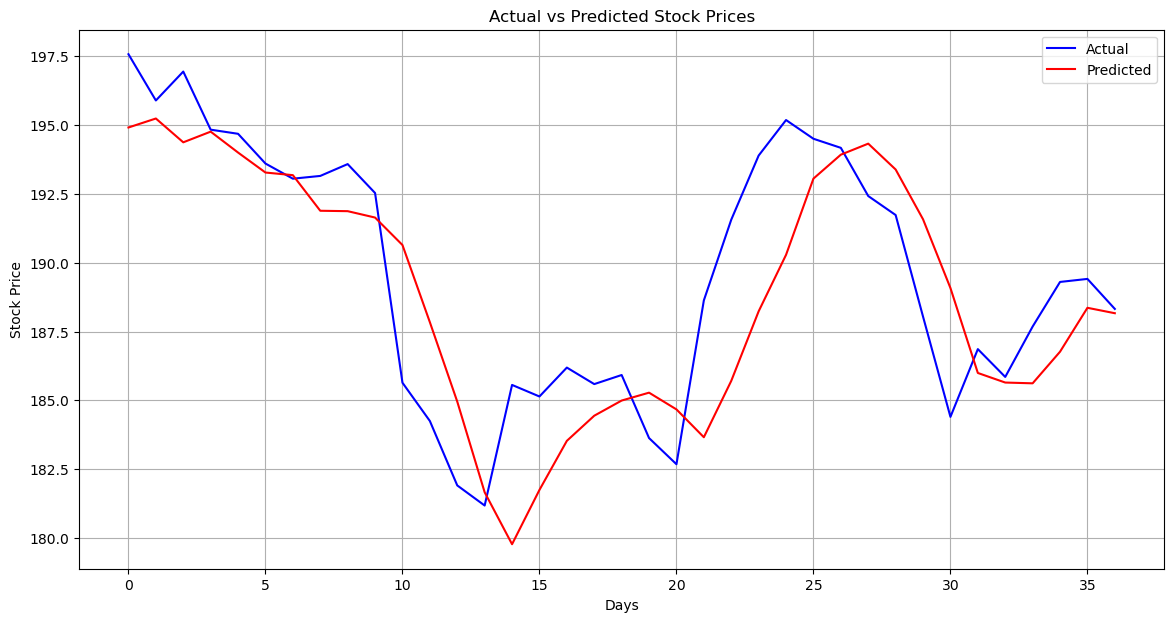

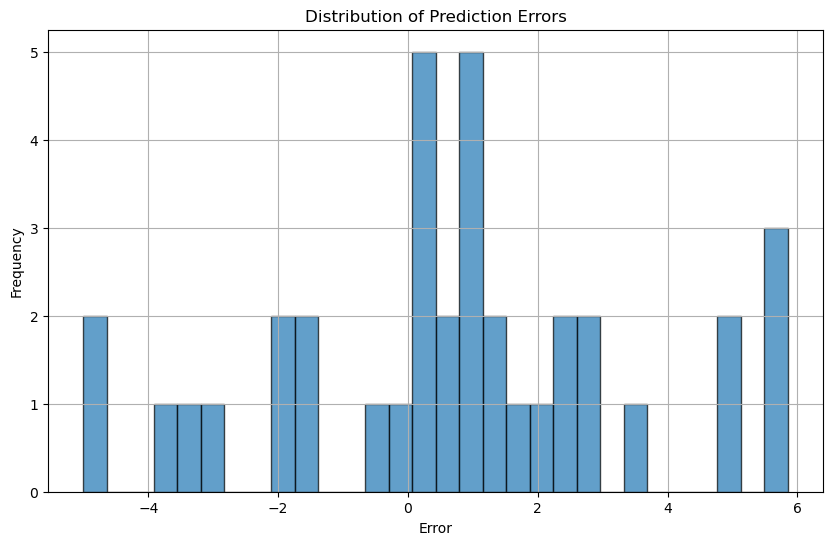

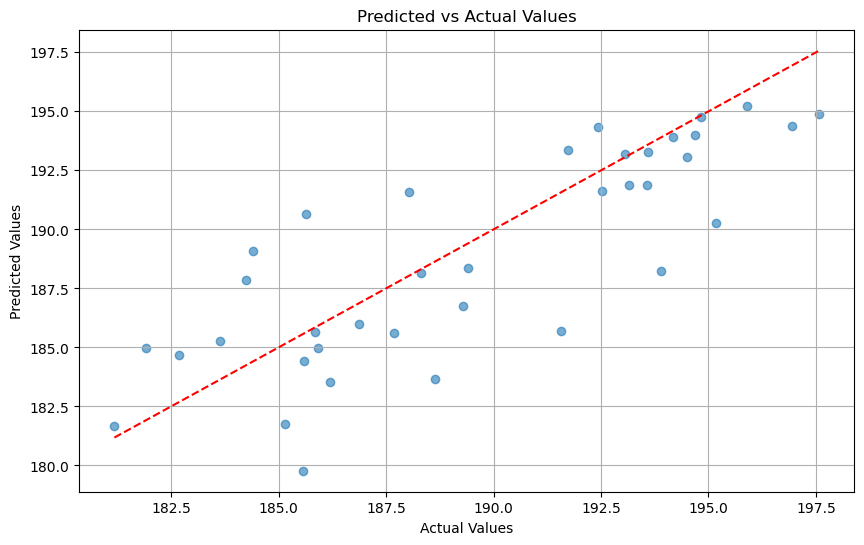

In [25]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, Nadam
from datetime import datetime, timedelta
from yahoo_fin import stock_info as si
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import ParameterGrid

# Set a random seed for reproducibility
np.random.seed(42)

# Fetch historical data for the past two years up until 2024-02-09
end_date = datetime(2024, 2, 9)
start_date = end_date - timedelta(days=2*365)  # Approximately two years

# Get historical data for AAPL
data = si.get_data('AAPL', start_date=start_date, end_date=end_date)

# Reset index to have a column with dates and rename it to 'date'
data.reset_index(inplace=True)
data.rename(columns={'index': 'date'}, inplace=True)

# Calculate technical indicators
data['SMA_10'] = data['close'].rolling(window=10).mean()
delta = data['close'].diff(1)
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
data['RSI_14'] = 100 - (100 / (1 + rs))
data['20_SMA'] = data['close'].rolling(window=20).mean()
data['20_std'] = data['close'].rolling(window=20).std()
data['Upper_Band'] = data['20_SMA'] + (data['20_std'] * 2)
data['Lower_Band'] = data['20_SMA'] - (data['20_std'] * 2)
data['Close_1'] = data['close'].shift(1)
data['Close_2'] = data['close'].shift(2)

# Drop rows with NaN values (due to shifting and rolling calculations)
data.dropna(inplace=True)

# Select the features and normalize
features = ['close', 'SMA_10', 'RSI_14', 'Upper_Band', 'Lower_Band', 'Close_1', 'Close_2']
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[features])

# Split the dataset into training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Convert the data into sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 0])  # '0' refers to the 'close' column
    return np.array(X), np.array(y)

seq_length = 60
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Reshape the input to be 3-dimensional [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], len(features)))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], len(features)))

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

# Define the hyperparameters grid
param_grid = {
    'units': [50, 100],
    'dropout': [0.2, 0.3],
    'optimizer': [Adam, RMSprop, Nadam],
    'batch_size': [32, 64],
    'learning_rate': [0.001, 0.005]
}

# Create the parameter grid
grid = list(ParameterGrid(param_grid))

# Initialize variables to store the best model and its performance
best_model = None
best_performance = float('inf')

# Perform grid search
for params in grid:
    print(f"Training with params: {params}")
    
    # Build the LSTM model with current hyperparameters
    model = Sequential()
    model.add(LSTM(units=params['units'], return_sequences=True, input_shape=(seq_length, len(features))))
    model.add(Dropout(params['dropout']))
    model.add(LSTM(units=params['units'], return_sequences=False))
    model.add(Dropout(params['dropout']))
    model.add(Dense(units=25))
    model.add(Dense(units=1))
    
    # Compile the model with the current optimizer and learning rate
    optimizer = params['optimizer'](learning_rate=params['learning_rate'])
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    # Train the model
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=50, batch_size=params['batch_size'], validation_data=(X_test, y_test), callbacks=[early_stop], verbose=0)
    
    # Make predictions
    test_predictions = model.predict(X_test)
    
    # Inverse transform the predictions and actual values
    test_predictions = scaler.inverse_transform(np.concatenate((test_predictions, np.zeros((test_predictions.shape[0], len(features) - 1))), axis=1))[:, 0]
    y_test_actual = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], len(features) - 1))), axis=1))[:, 0]
    
    # Evaluate the model
    rmse = np.sqrt(mean_squared_error(y_test_actual, test_predictions))
    
    # Update the best model if current model is better
    if rmse < best_performance:
        best_performance = rmse
        best_model = model
        best_params = params

print(f"Best RMSE: {best_performance}")
print(f"Best Parameters: {best_params}")

# Evaluate the best model with additional metrics
y_test_actual = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], len(features) - 1))), axis=1))[:, 0]
test_predictions = best_model.predict(X_test)
test_predictions = scaler.inverse_transform(np.concatenate((test_predictions, np.zeros((test_predictions.shape[0], len(features) - 1))), axis=1))[:, 0]

mae = mean_absolute_error(y_test_actual, test_predictions)
rmse = np.sqrt(mean_squared_error(y_test_actual, test_predictions))
r2 = r2_score(y_test_actual, test_predictions)
mape = np.mean(np.abs((y_test_actual - test_predictions) / y_test_actual)) * 100

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")
print(f"MAPE: {mape}")

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, label='Actual', color='blue')
plt.plot(test_predictions, label='Predicted', color='red')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

# Residuals plot
residuals = y_test_actual - test_predictions
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Prediction Errors')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Scatter plot of predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test_actual, test_predictions, alpha=0.6)
plt.plot([min(y_test_actual), max(y_test_actual)], [min(y_test_actual), max(y_test_actual)], color='red', linestyle='--')
plt.title('Predicted vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()
